## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import least_squares,minimize
from scipy.integrate import simpson

## Constants

In [2]:
NA = 6.02214076E23  # Avogadro's number
Ntrue = 217 #Number of ions used
N_s = 217 #Number of ions used
k = 0.785  # units: kJ/mol/nm^2 - force constant being used in calculations
R = 8.31446261815324  # units: J/(mol*K) - ideal gas constant
T = 300  # units: K - temperature used for calculations
L_x, L_y, L_z = 4.8, 4.8, 14.4

## Extra info

In [3]:
# # Alirezza SI nm-based answers
# print(1.9247 / (conversion_factor ** (-0.5)))
# print(9.3393E-2 / (conversion_factor ** (-1)))
# print(3.4572E-2 / (conversion_factor **(-2)))

<!-- exp_osm_coeff=0.936,molarity=0.976*(mole/litre)
exp_osm_coeff=0.984,molarity=1.923*(mole/litre)
exp_osm_coeff=1.045,molarity=2.823*(mole/litre) -->

## Plotting initial concentration profiles

In [4]:
def compute_c_profile(xvg_file):
    """
    Computes a concentration profile from an XVG file by averaging symmetric parts of the profile.

    Parameters
    ----------
    xvg_file : str
        The path to the XVG file containing the number density data.
    
    Returns
    -------
    z_coords : numpy.ndarray
        The z-coordinates of the concentration profile.
    c_profile : numpy.ndarray
        The symmetric concentration profile.
    """
    z_coords, rho = np.loadtxt(xvg_file, comments=["@", "#"], unpack=True)
    # rho = rho / NA * 1E27 / 1000  # number density in mol/L

    mid_idx = int(len(rho) / 2 - 1)
    c_profile = 0.5 * (rho[:mid_idx + 1][::-1] + rho[mid_idx:-1])  # in mol/L
    z_coords = z_coords[:mid_idx + 1]  # in nm

    return z_coords, c_profile


In [5]:
z, c_original = compute_c_profile("density_hw_35_original.txt")
z, c_1 = compute_c_profile("density_hw_35_r1.txt")  # replicate 1
z, c_2 = compute_c_profile("density_hw_35_r2.txt")  # replicate 2
z, c_3 = compute_c_profile("density_hw_35_r3.txt")  # replicate 3

In [6]:
np.shape(c_2)

(144,)

In [7]:
# List concentration profiles
concentration_profiles = np.array([c_original,c_1,c_2,c_3])

### Normalizing Densities

Note from Dr Shirts: It is more rigorous to normalize the densities, since we know what the total number must be. 

Eq 13: $$ L_{x} L_{y} \int^{L_{z}/2}_{-L_{z}/2} C_{s}(z) dz = N_{s}$$

In [8]:
# Estimate the total number of ions, N_s (using Equation 13)

for c in concentration_profiles:
    N_s = L_x * L_y * simpson(c, x=z)
    print(N_s)  # this should compare to number of ions used (3m used 188)
    c /= (N_s/Ntrue)
    
# verify normalization worked.
for c in concentration_profiles:
    N_s = L_x * L_y * simpson(c, z)
    print(N_s)  # compare to number of ions used (3m used 188)
    

250.91873398362353
251.05262082164887
250.7312303730805
250.91873398362353
216.99999999999991
217.0
216.99999999999997
216.99999999999991


/tmp/ipykernel_339308/609993702.py:10: DeprecationWarning: You are passing x=[0.    0.05  0.1   0.151 0.201 0.251 0.301 0.351 0.401 0.452 0.502 0.552
 0.602 0.652 0.702 0.753 0.803 0.853 0.903 0.953 1.004 1.054 1.104 1.154
 1.204 1.254 1.305 1.355 1.405 1.455 1.505 1.556 1.606 1.656 1.706 1.756
 1.806 1.857 1.907 1.957 2.007 2.057 2.107 2.158 2.208 2.258 2.308 2.358
 2.409 2.459 2.509 2.559 2.609 2.659 2.71  2.76  2.81  2.86  2.91  2.961
 3.011 3.061 3.111 3.161 3.211 3.262 3.312 3.362 3.412 3.462 3.512 3.563
 3.613 3.663 3.713 3.763 3.814 3.864 3.914 3.964 4.014 4.064 4.115 4.165
 4.215 4.265 4.315 4.366 4.416 4.466 4.516 4.566 4.616 4.667 4.717 4.767
 4.817 4.867 4.917 4.968 5.018 5.068 5.118 5.168 5.219 5.269 5.319 5.369
 5.419 5.469 5.52  5.57  5.62  5.67  5.72  5.771 5.821 5.871 5.921 5.971
 6.021 6.072 6.122 6.172 6.222 6.272 6.322 6.373 6.423 6.473 6.523 6.573
 6.624 6.674 6.724 6.774 6.824 6.874 6.925 6.975 7.025 7.075 7.125 7.176] as a positional argument. Please change your i

In [9]:
print(N_s)

216.99999999999991


Note BM: could maybe code up a funciton to check the above ^

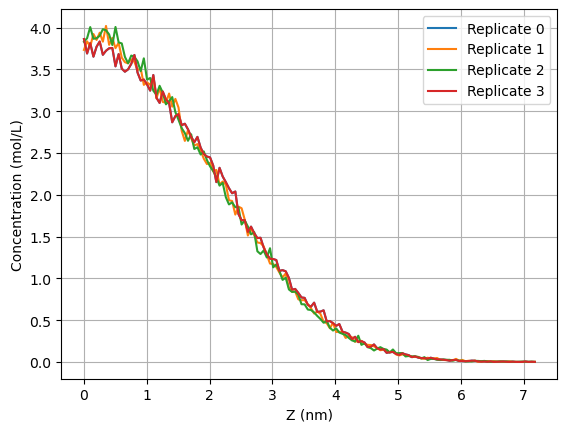

In [10]:
# Plot the concentration profiles (original and replicates)
plt.figure()
for i, c in enumerate(concentration_profiles):
    plt.plot(z, c, label="Replicate "+str(i))
plt.xlabel("Z (nm)")
plt.ylabel("Concentration (mol/L)")
plt.grid()
plt.legend()
plt.show()

## Calculating eq 12

$$ ln \left[ \frac{C_{s}(z)}{C_{max}} \right] + A \left[ \frac{C_{max}^{1/2}}{1+BC_{max}^{1/2}} - \frac{C_{s}(z)^{1/2}}{1+BC_{s}(z)^{1/2}} \right] + \sum^{i_{max}}_{i=1} \alpha_{i} [C_{s}(z)^{i} - C_{max}^{i}] = - \frac {U(z)}{RT}$$

In [11]:
def calc_y(theta, x):
    """
    Calculates -U(z) / RT using Equation 12.

    Parameters
    ----------
    theta : list
        A list containing the three parameters to be fit, including B, alpha_1, alpha_2.
    x : concentration list
    """
    A = 1.7964  # in M^(-1/2), value according to the SI

    # Converting the units for A so that they are nm-based
    conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
    A /= (conversion_factor ** 0.5)

    C_max = np.max(x)
    term_1 = np.log(x / C_max)
    term_2 = -A * np.sqrt(x) / (1 + theta[0] * np.sqrt(x))
    term_3 = A * np.sqrt(C_max) / (1 + theta[0] * np.sqrt(C_max))
    term_4 = theta[1]* (x - C_max) 
    term_5 = theta[2] * (x ** 2 - C_max ** 2)
    y = term_1 + term_2 + term_3 + term_4 + term_5

    return y

def residuals(theta, x, y):
    return np.power(calc_y(theta, x) - y, 2)

In [12]:
#Use the direct average rather than over bootstrap means
mean_profile = np.mean(concentration_profiles,axis=0)
c_0 = mean_profile

# Removing 0 values from the concentration profile, and the corresponding z values
z_fit = z[c_0 != 0]
c_fit = c_0[c_0 != 0]

In [13]:
A = 1.7964  # in M^(-1/2), value according to the SI

# Converting the units for A so that they are nm-based
conversion_factor = 1E24 / NA  # 1 nm^(-3) ~= 1.6605 M
A /= (conversion_factor ** 0.5)

In [14]:
# Right side/ y of equation 12
y_values = -(0.5 * k * z_fit ** 2) * 1000 / (R * T) 

#Getting fit for full left side of eq 12
result_unweighted = least_squares(residuals, [4, 0.2, 0], args=(c_fit, y_values))

## Plotting unweighted results

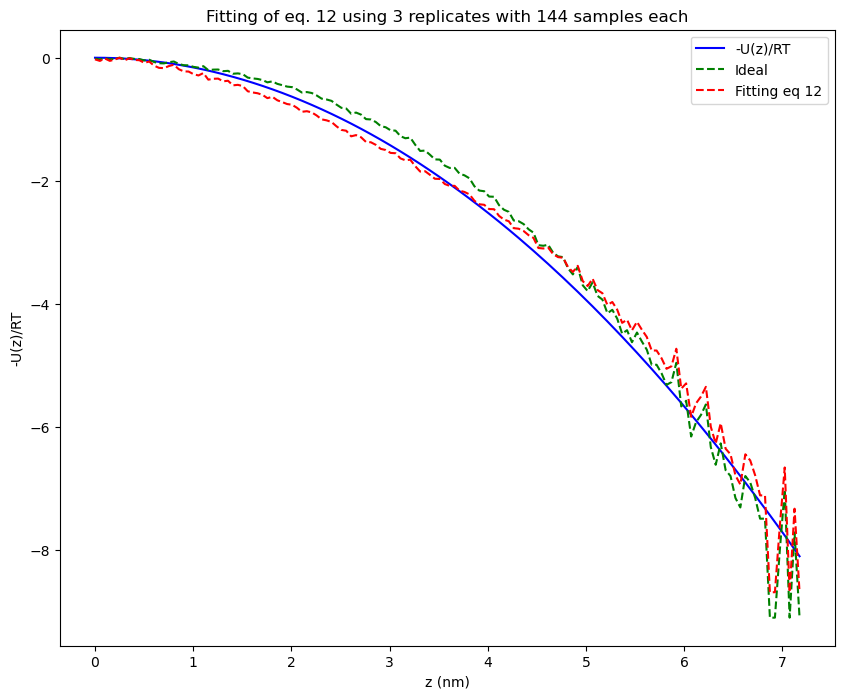

In [15]:
# plot the unweighted results
plt.figure(figsize = (10,8))
plt.plot(z_fit, y_values, 'b', label="-U(z)/RT")
plt.plot(z_fit, np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
plt.plot(z_fit, calc_y(result_unweighted.x,c_fit), 'r--', label="Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()

We do see reasonably good fit - the idea curve (green line) is corrected to the be closer to the blue (red line is closer tothe blue line). However, we would also like to not fit the noise at the end. 

To do this, we do some error propagation to find the ideal weights for the least square fit. $C(z)/C_{max}$ is a probability, or at least proportional to a probability.  The uncertainty in a probability estimate $\hat{p}$ from a histogram (whose value with infinitely collected points would be $p$), can be shown to be $\sqrt{\frac{\hat{p}(1-\hat{p})}{n}}$, where $\hat{p}$ is the measured probability in that histogram bin, and $n$ is the total number of points collected over all bins.  But we are interested in the error of $\ln \hat{p}$. Generally the error in function $f$ of random variable $x$ $\delta f(x)$ is equal to $|f'(x)| \delta x$. So $\delta (\ln p) = \frac{\delta p}{p} = \sqrt{\frac{\hat{p}(1-\hat{p})}{n\hat{p}^2}}$.

For weighted least squares, it can be show that the weights should be proportional to 1/variance of the data point. The variance will be $(\delta\ln p)^2 = \frac{\hat{p}(1-\hat{p})}{n\hat{p}^2} = \frac{1-\hat{p}}{np}$.  The weights are only defined up to a constant, so we can just use $\frac{1-p}{p}$.  To do this, we have to normalize $C/C_{max}$, which is easy to do, we call it K. So the weights should be proportional to $\frac{C/K}{1-C/K} = \frac{C}{K-C}$.  So the most well defined points will get the most probability, the noisiest points the least.

## Find weights for least square fit

In [16]:
norm = N_s/(L_x*L_y)
print(norm)

9.418402777777775


In [17]:
def weighted_residuals(theta, x, y):
    return (x/(norm-x))*np.power(calc_y(theta, x) - y, 2)

In [18]:
#Getting fit for full left side of eq 12
result_weighted = least_squares(weighted_residuals, [4, 0.2,-0.01], args=(c_fit, y_values))

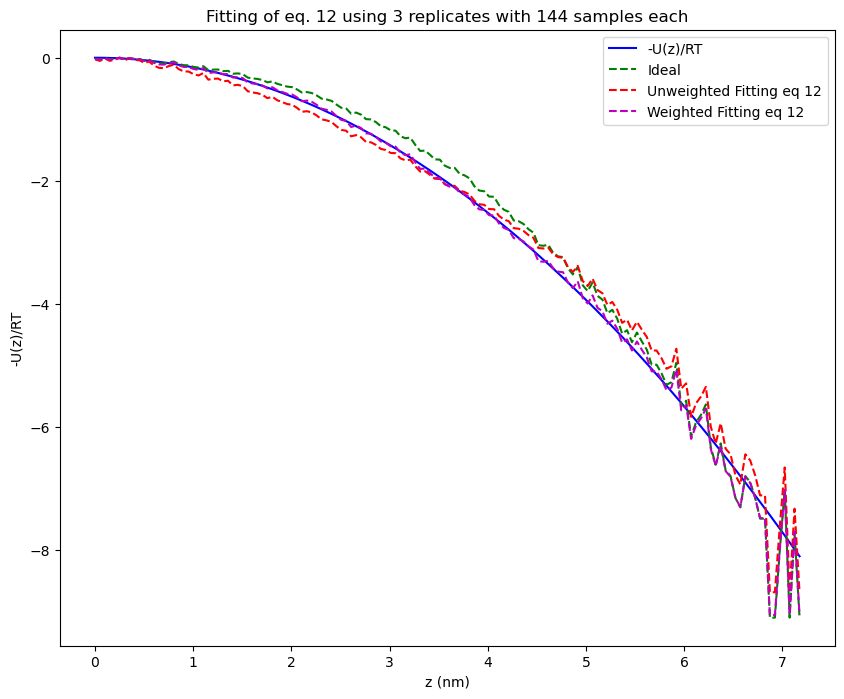

In [19]:
# plot the results
plt.figure(figsize = (10,8))
plt.plot(z_fit, y_values, 'b', label="-U(z)/RT")
plt.plot(z_fit, np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
plt.plot(z_fit, calc_y(result_unweighted.x,c_fit), 'r--', label="Unweighted Fitting eq 12")
plt.plot(z_fit, calc_y(result_weighted.x,c_fit), 'm--', label="Weighted Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()

Hard to see what is going on, so let's look at differences

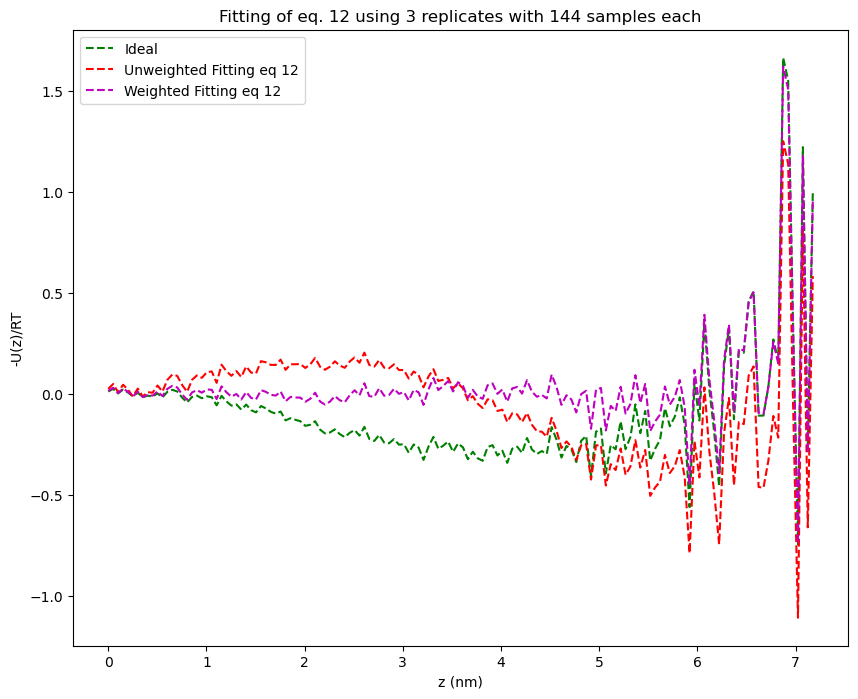

In [20]:
# plot the results. Notice the plots are now being subtracted from the y_values results
plt.figure(figsize = (10,8))
plt.plot(z_fit, y_values-np.log(c_fit/np.max(c_fit)), 'g--', label="Ideal")
plt.plot(z_fit, y_values-calc_y(result_unweighted.x,c_fit), 'r--', label="Unweighted Fitting eq 12")
plt.plot(z_fit, y_values-calc_y(result_weighted.x,c_fit), 'm--', label="Weighted Fitting eq 12")
plt.xlabel('z (nm)')
plt.ylabel('-U(z)/RT')
plt.title('Fitting of eq. 12 using 3 replicates with 144 samples each')
plt.legend()
plt.show()

The weighted fitting is much closer to zero over the range with reasonable concentrations, say z=5.

In [21]:
zlim = 4 #coordinate limit for where fitting is closer

In [22]:
#Stdev of unweighted results
np.std(y_values[z_fit<zlim]-calc_y(result_unweighted.x,c_fit[z_fit<zlim]))

0.06467563369317485

In [23]:
#Stdev of weighted results
np.std(y_values[z_fit<zlim]-calc_y(result_weighted.x,c_fit[z_fit<zlim]))

0.027132285053230513

Compare the distribution of the parameters with the fit!

In [24]:
print("B =", result_unweighted.x[0])
print("alpha1 =", result_unweighted.x[1])
print("alpha2 =", result_unweighted.x[2])

B = 0.00022772730186608475
alpha1 = 0.5991728814134545
alpha2 = -0.0014410213185432957


In [25]:
print("B =", result_weighted.x[0])
print("alpha1 =", result_weighted.x[1])
print("alpha2 =", result_weighted.x[2])

B = 1.3097884227364407
alpha1 = 0.2791415104797108
alpha2 = -0.02576868558728568


And we expect that the parameters will be more consistent between runs with weighting.

## Bootstrapping Profiles (without and with weights)

In [26]:
trialp = [4, 0.1,0.0]

In [27]:
# Function to perform bootstrapping
def bootstrap_profiles(profiles, n_samples, res_func):
    bootstrap_params = []
    n_profiles = len(profiles)
    for _ in range(n_samples):
        # Resample with replacement
        bootstrap_sample = [profiles[np.random.randint(0, n_profiles)] for _ in range(n_profiles)]
        # Calculate mean profile
        mean_profile = np.mean(bootstrap_sample, axis=0)
        z_fit = z[mean_profile != 0]
        c_fit = mean_profile[mean_profile != 0] 
        y_values = -(0.5 * k * z_fit ** 2) * 1000 / (R * T)
        result = least_squares(res_func, trialp, args=(c_fit, y_values))
        bootstrap_params.append(result.x)
        
    return np.array(bootstrap_params) # list

Param 0 = 0.007063976966708907 +/- 0.09035727439936038


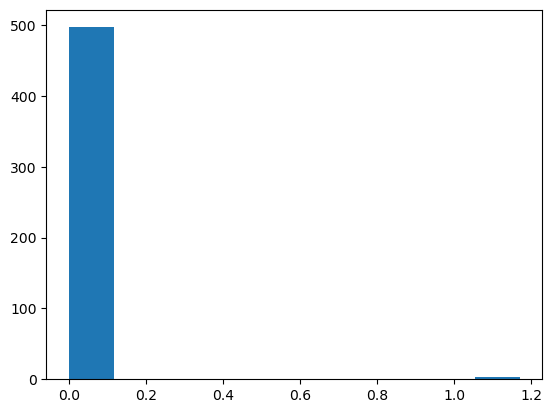

Param 1 = 0.7117954557066447 +/- 0.13764801778534388


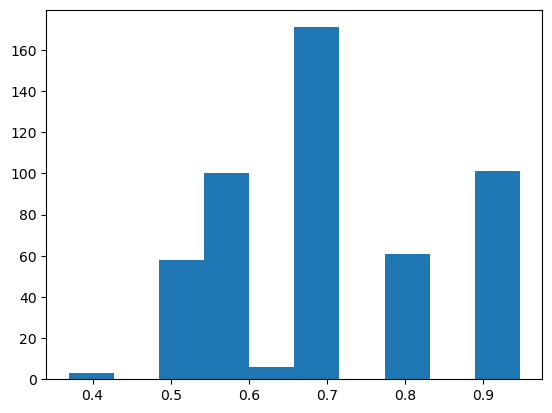

Param 2 = -0.025555735222591743 +/- 0.028267498884151313


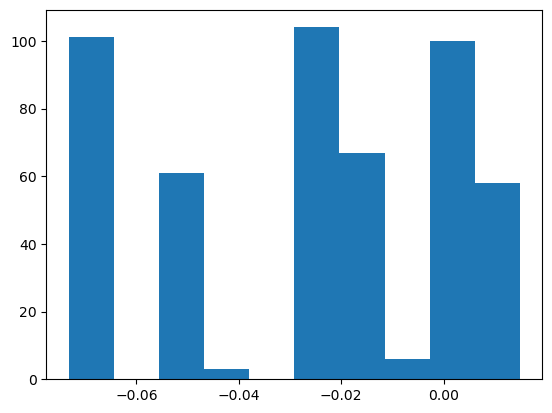

In [28]:
# Perform bootstrapping with unweighted fit
bootstrap_params_unweighted = bootstrap_profiles(profiles=concentration_profiles, n_samples=500, res_func=residuals)

for i in range(len(trialp)):
    pd = bootstrap_params_unweighted[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Param {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

Param 0 = 1.1152593046307477 +/- 0.3681648873167889


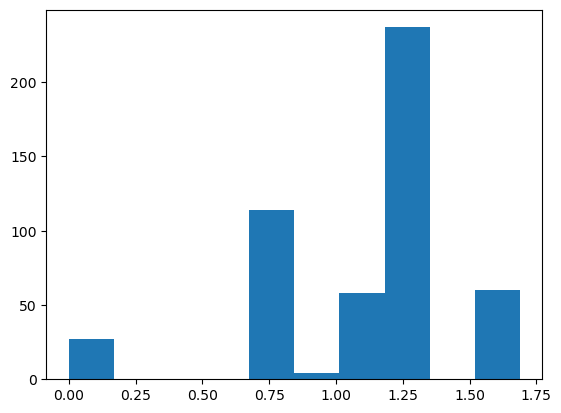

Param 1 = 0.3493615559371923 +/- 0.14898111997211733


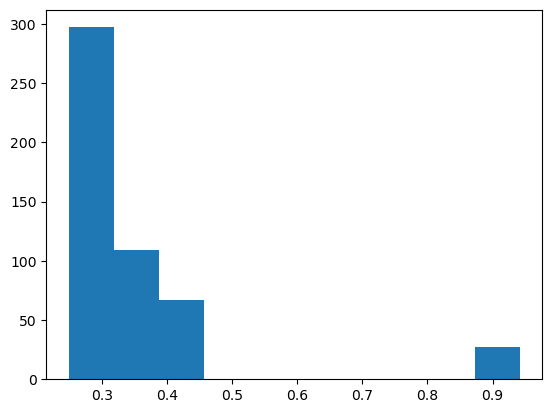

Param 2 = -0.03337808654962934 +/- 0.010578682786638609


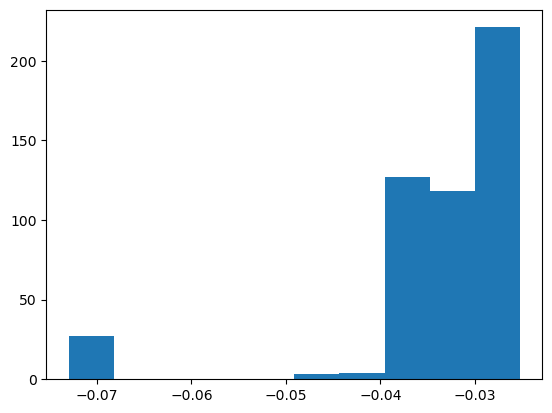

In [29]:
# Perform bootstrapping with weighted residuals
n_bootstrap = 500
bootstrap_params_weighted  = bootstrap_profiles(profiles=concentration_profiles, n_samples=500, res_func=weighted_residuals)

for i in range(len(trialp)):
    pd = bootstrap_params_weighted[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Param {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

Much more consistent performance!

## Maximum Likelihood Parameter Optimization

Now, we try maximum likelihood parameter optimization.  The basic idea is to express the probability of parameters given the data, $P(a|x)$, and using Bayes' rule to find that 

$P(a|x) = \frac{P(x|a)P(a)}{P(x)}$

We want to find the parameters 
$P(x)$ does not depend on the parameters. If we assume no prior information about the parameters $P(a)$ (that would be Bayesian inference), then we have.

$P(a|x) \propto P(x|a)$

So we need to maximize the probability given the data $P(\vec{x}|a)$. Assuming the samples are independent, then the total probability given all of the data is $\prod_{i=1}^N P(x_i|a)$.  

Since the logarithm is a monotonic function, then maximizing $\ln P(\vec{x}|a) = \sum_{i=1}^N \ln P(x_i|a)$ is the same as maximizing $P(\vec{x}|a$).

### The actual problem

We now apply the problem to the one of the chemical potential of ions trapped in a harmonic potential.

First, import the data.

In [30]:
import pickle
import pdb
import MDAnalysis as mda

In [32]:
u = mda.Universe('md.pdb', 'md.xtc')
u.transfer_to_memory()
ions= u.select_atoms('resname NA CL')

u1 = mda.Universe('mdr1.pdb', 'mdr1.xtc')
u1.transfer_to_memory()
ions1= u1.select_atoms('resname NA CL')

u2 = mda.Universe('mdr2.pdb', 'mdr2.xtc')
u2.transfer_to_memory()
ions2= u2.select_atoms('resname NA CL')

u3 = mda.Universe('mdr3.pdb', 'mdr3.xtc')
u3.transfer_to_memory()
ions3= u3.select_atoms('resname NA CL')

In [33]:
def get_ion_array(u,ions):
    ion_array=[]
    for ts in u.trajectory:
        ions_z = ions.positions[:,2]
        ion_array.append(ions_z)
    ionz = np.abs(np.array(ion_array)-72)/10  # rescale the data
    zvals=ionz.flatten()
    print(len(zvals))
    return zvals
zvals={}
zvals['original']=get_ion_array(u,ions)
zvals['r1']=get_ion_array(u1,ions1)
zvals['r2']=get_ion_array(u2,ions2)
zvals['r3']=get_ion_array(u3,ions3)


108500
108500
108500
108500


For this problem, we are essentially finding the parameters that examine the probability of finding an ion at a given $x$, since concentration is proportional to probability.  

We convert the concentration $C(z)/C_{max}$ to an unnormalized probability $p(z)$.  

$\ln p(z|B,\alpha_1,\alpha_2) \propto \ln \frac{C(z)}{C_{max}}$

$\ln \frac{C(z)}{C_{max}} = \sum_i -\frac{kz^2}{2RT} + A\left(\frac{C(z)^{1/2}}{1+BC(z)^{1/2}} - \frac{C_{max}^{1/2}}{1+BC_{max}^{1/2}} \right) -\alpha_1(C(z)-C_{max}) - \alpha_2(C(z)^2-C_{max}^2)$  



$C_{max}$ and also the normalizing constant will be fixed by the fact that we have a fixed number of ions present.

This is actually not ideal for maximizing, since the concentration $c(z)$ occurs on both sides. It would be great if we could algebraically solve for $c(z)$, but this does not appear to be possible.

We can't actually leave out any of the terms, because all of the terms involve the parameters implicitly (including $C_{max}$).

We approach the problem the following way:

 - Given a set $[B,\alpha_1,\alpha_2]$, find the concentration $C(z|B,\alpha_1,\alpha_2)$ that satisfies those parameters. 
 - This will need to be done self-consistently, as each time the parameters change, $C_{max}$ will also change.
 - We will make use of a reference ideal distribution with no parameters.


Define the ideal solution function which satisfies the normalization and find the $C_{max}$ for this solution, i.e. 

$N_p = L_x L_y C_{max} \int_0^{\infty} p(z|B,\alpha_1,\alpha_2) dz$

$C_{max} = \frac{ N_p }{L_x L_y} \left(\int_0^{\infty} p(z|B,\alpha_1,\alpha_2\right) dz )^{-1}$

In [34]:
from scipy.integrate import quad, simpson, trapezoid

In [35]:
red_U_app = lambda z: 1000*k*z*z/(2*R*T) #left side of eq 12
cz_ideal = lambda z: np.exp(-red_U_app(z)) 

#Should not hard code k

In [36]:
ideal_norm = quad(cz_ideal,0,10)[0]
print(ideal_norm)
ideal_norm = np.sqrt(np.pi*R*T/(2*1000*k))
print(ideal_norm)

#are we checking these both yield approx the same?
#where did the second equation come from? Why pi?

2.2341010940709776
2.2341011392922034


In [37]:
cmax_ideal=N_s/(L_x*L_y*ideal_norm)
print(cmax_ideal)

#same as cell above?

4.215745926686947


One issue is doing the integration of the model parameter to normalize it. 

We could try to take advantage of importance sampling - if we have two unnormalized probability distributions $q_i$ and $q_j$ ($p_i$ normalized), and we have samples from $q_i$, then we can have

$1 = \int p_j(z) dz \\
= \int \frac{p_j(z)}{p_i(z)}p_i(z) \\
= \int \frac{q_j(z)/Z_j}{q_i(z)/Z_i} p_i(z) \\
= \int \frac{Z_i}{Z_j} \frac{q_j(z)}{q_i(z)} p_i(z) \\
\approx \frac{Z_i}{Z_j} \frac{1}{N} \sum_n \frac{q_j(z_n)}{q_i(z_n)} \\
\frac{Z_i}{Z_j} \approx \frac{1}{N} \sum_n \frac{q_j(z_n)}{q_i(z_n)}
$

 So if we know the ideal solution normalizing factor, we can find

$Z_{trial} = Z_{ideal} \frac{1}{N} \sum_n \frac{q_{ideal}(z)}{q_{trial}(z)} =  Z_{ideal} \left \langle \frac{q_{ideal}(z)}{q_{trial}(z)} \right \rangle$

However, this doesn't actually appear work if we using this equation to optimize the parameters, because if we have a mismatch between the trial function and the data sampled; if the trial function functional form doesn't actually match the PDF measured, then we will continually get worse results.

Let's do something silly/simple and assume we have enough data, and just take the points that are output, and do Simpson's rule on those.

In [38]:
# define a function that iterates the calculation of a concentration.
def czfunc(a,z,cz):
    # exponential of eq 12 for ln c/cmax for the data points
    cznew = np.exp(logprobfunc(a,z,cz))
    # these indices do not need to be repeated if this is expensive,
    # but if we bootstrap, they will change, so keep for now. 
    zunique,locs = np.unique(z,return_index=True)
    # now we have sorted unique points, we can integrate
    newarea = simpson(cznew[locs],x=zunique)
    cznorm_ratio = ideal_norm/newarea
    return (cmax_ideal*cznorm_ratio)*cznew

In [39]:
def logprobfunc(a,z,cz,A=A):
    # we need to calculate the maximum concentration 
    cmax = np.max(cz) # this only works if a sample is at z=0: improve!                      
    czh = np.sqrt(cz)
    cmaxh = np.sqrt(cmax)
    term_1 = -red_U_app(z)
    term_2 = A*((czh/(1+a[0]*czh))-(cmaxh/(1+a[0]*cmaxh)))
    term_3 = - a[1]*(cz - cmax)
    term_4 = - a[2]*(cz**2 - cmax**2)
    return term_1 + term_2 + term_3 + term_4

In [40]:
def converge_c(params, z, cz_start,
               niter=1000,lim=0.0001,verbose=False):

    # hot start from ideal, otherwise use a good guess.
    if isinstance(cz_start,str):
        if cz_start == 'ideal':
            cz_start = cmax_ideal*cz_ideal(z)
            
    c_old = cz_start
    for i in range(niter):
        c_new = czfunc(params,z,c_old)
        norm = np.sqrt(np.dot(c_new-c_old,c_new-c_old))
        if verbose:
            print(i,norm)
        c_old = c_new
        if norm < lim:
            break

    return czfunc(params,z,c_new)

How many duplicates of each $z$ value are there?  

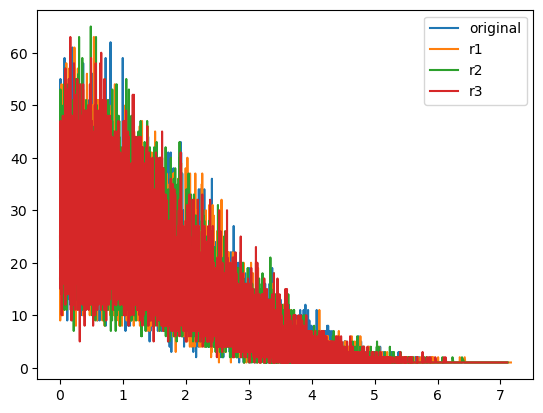

In [41]:
zsparse_o,zcount_o=np.unique(zvals['original'],return_counts=True)
zsparse_r1,zcount_r1=np.unique(zvals['r1'],return_counts=True)
zsparse_r2,zcount_r2=np.unique(zvals['r2'],return_counts=True)
zsparse_r3,zcount_r3=np.unique(zvals['r3'],return_counts=True)
plt.plot(zsparse_o,zcount_o,label='original')
plt.plot(zsparse_r1,zcount_r1,label='r1')
plt.plot(zsparse_r2,zcount_r2,label='r2')
plt.plot(zsparse_r3,zcount_r3,label='r3')
plt.legend()
plt.show()

Turns out, quite a few!  We can take advantage of that; each time the same $z$ is processed, it would result in the same number, so we can calculate the contribution for each $z$ once and then mulitply by the number of times it appears.

0 57.77684
1 6.331999
2 1.0699557
3 0.19498654
4 0.03745752
5 0.007444716
6 0.0016095744
7 0.00058034615
0 58.15234
1 6.330224
2 1.0688182
3 0.19458897
4 0.037474405
5 0.0073065334
6 0.001441271
7 0.00031377698
0 58.36886
1 6.3172545
2 1.0642493
3 0.19348516
4 0.036966078
5 0.0072797216
6 0.0019105542
7 0.00033563309
0 58.094387
1 6.346966
2 1.0706936
3 0.19462344
4 0.037288867
5 0.0073628817
6 0.0014889123
7 0.0010967231
8 0.00033791366


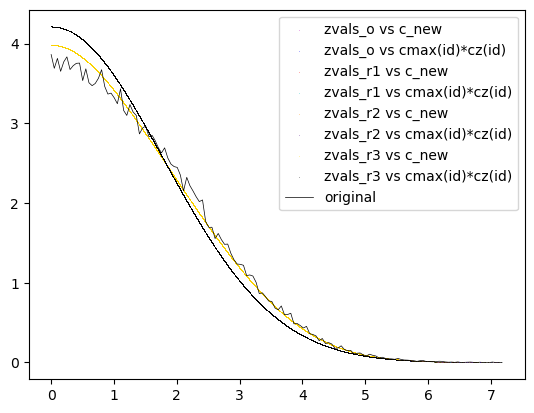

In [42]:
newp = np.array([1.35,0.33,-0.04])
c_new_o = converge_c(newp,zvals['original'],cz_start='ideal',lim=0.001,verbose=True)
c_new_r1 = converge_c(newp,zvals['r1'],cz_start='ideal',lim=0.001,verbose=True)
c_new_r2 = converge_c(newp,zvals['r2'],cz_start='ideal',lim=0.001,verbose=True)
c_new_r3 = converge_c(newp,zvals['r3'],cz_start='ideal',lim=0.001,verbose=True)
plt.scatter(zvals['original'],c_new_o,s=0.1,lw=0.1,c='m', label='zvals_o vs c_new')
plt.scatter(zvals['original'],cmax_ideal*cz_ideal(zvals['original']),s=0.1,lw=0.1,c='b', label='zvals_o vs cmax(id)*cz(id)')
plt.scatter(zvals['r1'],c_new_r1,s=0.1,lw=0.1,c='r', label='zvals_r1 vs c_new')
plt.scatter(zvals['r1'],cmax_ideal*cz_ideal(zvals['r1']),s=0.1,lw=0.1,c='c', label='zvals_r1 vs cmax(id)*cz(id)')
plt.scatter(zvals['r2'],c_new_r2,s=0.1,lw=0.1,c='darkorange', label='zvals_r2 vs c_new')
plt.scatter(zvals['r2'],cmax_ideal*cz_ideal(zvals['r2']),s=0.1,lw=0.1,c='indigo', label='zvals_r2 vs cmax(id)*cz(id)')
plt.scatter(zvals['r3'],c_new_r3,s=0.1,lw=0.1,c='gold', label='zvals_r3 vs c_new')
plt.scatter(zvals['r3'],cmax_ideal*cz_ideal(zvals['r3']),s=0.1,lw=0.1,c='black', label='zvals_r3 vs cmax(id)*cz(id)')
plt.plot(z,concentration_profiles[0],'k',lw=0.5, label='original')
plt.legend()
plt.show()

0 14.3258095
1 1.6678251
2 0.284118
3 0.052092507
4 0.010015348
5 0.0019845539
6 0.00041690966
0 14.322321
1 1.6677511
2 0.28411072
3 0.052101303
4 0.010035981
5 0.0019709165
6 0.0003940745
0 14.32624
1 1.6678146
2 0.28411144
3 0.052095007
4 0.009998603
5 0.001974246
6 0.00047149826
0 14.324451
1 1.6677192
2 0.2841155
3 0.05206617
4 0.010004995
5 0.0019776425
6 0.00041100866


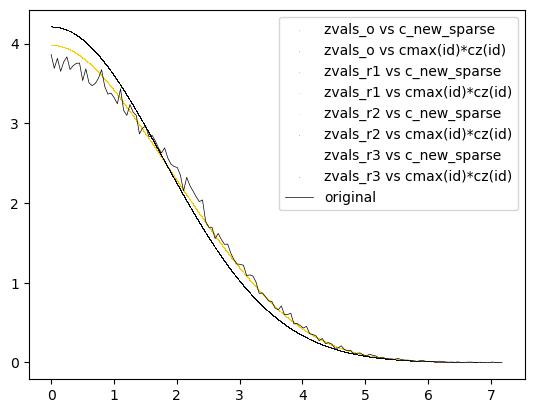

In [43]:
# we can converge faster with sparse data. (?)
c_new_sparse_o = converge_c(newp,zsparse_o,cz_start='ideal',lim=0.001,verbose=True)
c_new_sparse_r1 = converge_c(newp,zsparse_r1,cz_start='ideal',lim=0.001,verbose=True)
c_new_sparse_r2 = converge_c(newp,zsparse_r2,cz_start='ideal',lim=0.001,verbose=True)
c_new_sparse_r3 = converge_c(newp,zsparse_r3,cz_start='ideal',lim=0.001,verbose=True)
plt.scatter(zsparse_o,c_new_sparse_o,s=0.1,lw=0.1,c='m', label='zvals_o vs c_new_sparse')
plt.scatter(zsparse_o,cmax_ideal*cz_ideal(zsparse_o),s=0.1,lw=0.1,c='b', label='zvals_o vs cmax(id)*cz(id)')
plt.scatter(zsparse_r1,c_new_sparse_r1,s=0.1,lw=0.1,c='r', label='zvals_r1 vs c_new_sparse')
plt.scatter(zsparse_r1,cmax_ideal*cz_ideal(zsparse_r1),s=0.1,lw=0.1,c='c', label='zvals_r1 vs cmax(id)*cz(id)')
plt.scatter(zsparse_r2,c_new_sparse_r2,s=0.1,lw=0.1,c='darkorange', label='zvals_r2 vs c_new_sparse')
plt.scatter(zsparse_r2,cmax_ideal*cz_ideal(zsparse_r2),s=0.1,lw=0.1,c='indigo', label='zvals_r2 vs cmax(id)*cz(id)')
plt.scatter(zsparse_r3,c_new_sparse_r3,s=0.1,lw=0.1,c='gold', label='zvals_r3 vs c_new_sparse')
plt.scatter(zsparse_r3,cmax_ideal*cz_ideal(zsparse_r3),s=0.1,lw=0.1,c='black', label='zvals_r3 vs cmax(id)*cz(id)')
plt.plot(z,concentration_profiles[0],'k',lw=0.5, label='original')
plt.legend()
plt.show()

In [44]:
def neglliter(a,z,cz_start,counts=None,lim=0.0001,verbose=False,print_val=False,doeval=False):
    if len(z)!= len(cz_start):
        print("x and y data does not match length")
        return
    if doeval == True:
        lim = 1
    # generate the new concentration with these parameters
    cz = converge_c(a,z,cz_start,lim=lim,verbose=verbose)
    # divide by cmax_ideal to make the numbers smaller, 
    # it's a constant so it doesn't affect the results     
    terms = np.log(cz/cmax_ideal)
    # if we don't know how many of each value there are,
    # just add them all up
    if counts is None:
        csum = np.sum(terms)
    else:
        # if we DO know how many of each value there are
        # then just do each value once, and multiply
        # by the number of counts
        csum = np.dot(counts,terms)
    if print_val:
        print("csum",csum)
    return -1*csum

In [45]:
from timeit import default_timer as timer

Note we can make this much faster by noting that there are a lot of repeats of each value, so we can simplify the sum (MIGHT be slightly different because of rounding).


In [46]:
# this is now much faster, and gives essentially the same answer.
start = timer()
results = minimize(neglliter,newp,args=(zsparse_o,c_new_sparse_o,zcount_o),method='Nelder-Mead')
end = timer()
print("time=",end-start)
print(results)
full_opt = results.x

time= 2.7076778530608863
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 60923.839940324426
             x: [ 1.752e+00  1.783e-01 -3.676e-03]
           nit: 126
          nfev: 267
 final_simplex: (array([[ 1.752e+00,  1.783e-01, -3.676e-03],
                       [ 1.752e+00,  1.783e-01, -3.676e-03],
                       [ 1.752e+00,  1.783e-01, -3.676e-03],
                       [ 1.752e+00,  1.783e-01, -3.676e-03]]), array([ 6.092e+04,  6.092e+04,  6.092e+04,  6.092e+04]))


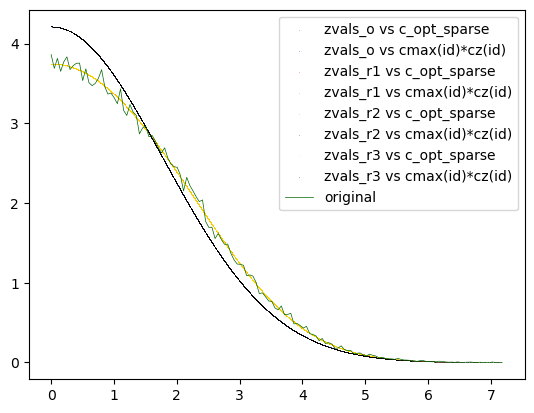

In [47]:
# now plot the new data 
c_opt_sparse_o = converge_c(results.x,zsparse_o,cz_start=c_new_sparse_o,verbose=False)
c_opt_sparse_r1 = converge_c(results.x,zsparse_r1,cz_start=c_new_sparse_r1,verbose=False)
c_opt_sparse_r2 = converge_c(results.x,zsparse_r2,cz_start=c_new_sparse_r2,verbose=False)
c_opt_sparse_r3 = converge_c(results.x,zsparse_r3,cz_start=c_new_sparse_r3,verbose=False)
plt.scatter(zsparse_o,c_opt_sparse_o,s=0.1,lw=0.1,c='m', label='zvals_o vs c_opt_sparse')
plt.scatter(zsparse_o,cmax_ideal*cz_ideal(zsparse_o),s=0.1,lw=0.1,c='b', label='zvals_o vs cmax(id)*cz(id)')
plt.scatter(zsparse_r1,c_opt_sparse_r1,s=0.1,lw=0.1,c='r', label='zvals_r1 vs c_opt_sparse')
plt.scatter(zsparse_r1,cmax_ideal*cz_ideal(zsparse_r1),s=0.1,lw=0.1,c='c', label='zvals_r1 vs cmax(id)*cz(id)')
plt.scatter(zsparse_r2,c_opt_sparse_r2,s=0.1,lw=0.1,c='darkorange', label='zvals_r2 vs c_opt_sparse')
plt.scatter(zsparse_r2,cmax_ideal*cz_ideal(zsparse_r2),s=0.1,lw=0.1,c='indigo', label='zvals_r2 vs cmax(id)*cz(id)')
plt.scatter(zsparse_r3,c_opt_sparse_r3,s=0.1,lw=0.1,c='gold', label='zvals_r3 vs c_opt_sparse')
plt.scatter(zsparse_r3,cmax_ideal*cz_ideal(zsparse_r3),s=0.1,lw=0.1,c='black', label='zvals_r3 vs cmax(id)*cz(id)')
plt.plot(z,concentration_profiles[0],'darkgreen',lw=0.5, label='original')
plt.legend()
plt.show()

Note that the parameters are somewhat different, but the curves are about the same; the space appears to be relatively degenerate, in that there's a large volume of parameters that all give similar results. But that's probably OK for osmotic coefficients, as there will also be many parameters that thus give about the same osmotic coefficient. 

This seems to work!  Things to do:

1. Implement bootstrapping. A key here is one can now bootstrap over all the SAMPLES (like 188,000), not the profiles (4).
2. See what happens when you use all the data from the trajectories.  You can just dump them all into one big array - the bootstrapping is on samples, not on the trajectories.
3. See if you can get away with 2 paramters, not 3, and still get a good fit.  
4. Bootstrap around the osmotic coefficient/pressure calculation given the curve - this will be much less noisy than the parameters themselves. 


In [48]:
# Function to perform bootstrapping over _samples_
def bootstrap_samples(samples, n_boot, minfunc, init_params):
    zinit=np.unique(samples)
    c_start = converge_c(init_params,zinit,cz_start='ideal',verbose=False)
    bootstrap_params = list()
    bootstrap_cs = list()
    n_samples = len(samples)
    for i in range(n_boot):
        # Resample with replacement
        indices = np.random.randint(0,n_samples,size=n_samples)
        bootstrap_sample = samples[indices]
        zsparse,zcount=np.unique(bootstrap_sample,return_counts=True)
        # we can't use the old concentrations since they are at potentially different z
        # so interpolate (should be negligible error)
        c_new = np.interp(zsparse,zinit,c_start)
        result = minimize(minfunc,init_params,args=(zsparse,c_new,zcount),method="Nelder-Mead")
        print(i,result.x,result.fun)
        bootstrap_params.append(result.x)
        # generate a converged concentration at this point. Make the locations
        # at the same points as the original
        c_new = converge_c(result.x,zsparse,cz_start=c_new)
        c_new = np.interp(zinit,zsparse,c_new)
        bootstrap_cs.append(c_new) 
    return np.array(bootstrap_params), np.array(bootstrap_cs)

In [49]:
zvals_all=[
    *zvals['original'],
    *zvals['r1'],
    *zvals['r2'],
    *zvals['r3'],
]

In [50]:
print(type(zvals_all))

<class 'list'>


In [51]:
zvals_all=np.array(zvals_all)

In [52]:
bparams,bcs = bootstrap_samples(zvals_all,500,neglliter,results.x)

0 [ 2.76160003e+00  1.22249683e-01 -1.67410015e-03] 239329.2794498193
1 [ 2.64251338  0.14417729 -0.00677763] 238977.99765736444
2 [ 2.41486469  0.13960277 -0.00520227] 238287.79181264358
3 [ 2.61024077  0.13205037 -0.00432957] 238362.84216207077
4 [ 2.66923696  0.13020335 -0.00425729] 238207.91494093917
5 [ 2.24489837  0.15568478 -0.00833891] 237939.81756814657
6 [ 2.40883215  0.14150097 -0.00495596] 238932.1368603228
7 [ 2.67437735e+00  1.18968457e-01 -1.25818966e-03] 238591.43490663572
8 [2.99159209e+00 1.04904443e-01 8.96137219e-04] 238660.47020642858
9 [ 2.05237641  0.177758   -0.01079647] 239381.93396789534
10 [ 2.04635287  0.166411   -0.00886938] 238535.86285674575
11 [ 2.454622    0.15293306 -0.00834362] 238576.52756648354
12 [ 2.28464099  0.14605916 -0.00650507] 237800.0117359533
13 [ 2.17401397  0.15810481 -0.00729637] 239078.42388176188
14 [ 2.8169501   0.12888327 -0.00381848] 239019.1332108608
15 [ 2.14341654  0.16127503 -0.00851573] 238400.17958959367
16 [ 2.70687957  0.12

In [53]:
zsparse_all,zcount_all=np.unique(zvals_all,return_counts=True)

In [54]:
# find what should be the single bootstrap optimum with all of the data.

In [55]:
c_new_sparse_all = converge_c(newp,zsparse_all,cz_start='ideal',lim=0.001,verbose=True)

0 14.368682
1 1.6693405
2 0.2841429
3 0.05207946
4 0.010005891
5 0.001956539
6 0.00041875042


In [56]:
results = minimize(neglliter,newp,args=(zsparse_all,c_new_sparse_all,zcount_all),method='Nelder-Mead')
full_opt=results.x
print(full_opt)
c_opt_sparse_all = converge_c(full_opt,zsparse_all,cz_start=c_new_sparse_all,verbose=False)

[ 1.72168609  0.19379308 -0.01261432]


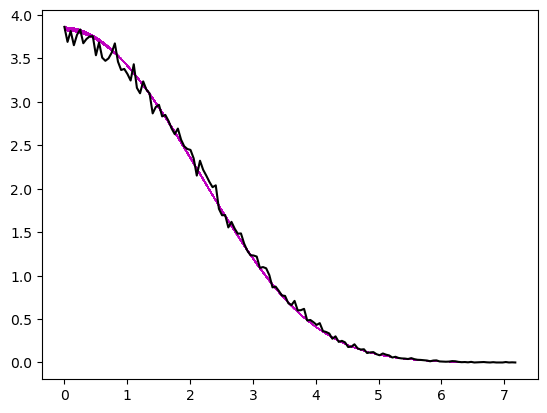

In [57]:
# now plot the new data 
for i in range(len(bcs)):    
    plt.scatter(zsparse_all,bcs[i],s=0.1,lw=0.1,c='m')
plt.plot(z,concentration_profiles[0],'k')
plt.show()

In [58]:
# compute the correlation coefficients
stdparam = np.std(bparams,axis=0)
mxy = np.outer(stdparam,stdparam) #<x><y>
covparam = np.cov(bparams.T,ddof=0) # <xy>
#print(covparam)
covcorr = covparam/mxy
print(covcorr)

[[ 1.         -0.9055501   0.82301214]
 [-0.9055501   1.         -0.97780175]
 [ 0.82301214 -0.97780175  1.        ]]


Note that parameters are highly correlated, as you can see by the correlation matrix  - there are multiple parameters that give essentially the same result. It may be a 2 parameter fit is enough!  Bootstrapping over osmotic coefficients should give less noisy results.

Parma 0 = 2.483067887960466 +/- 0.3440668043850953


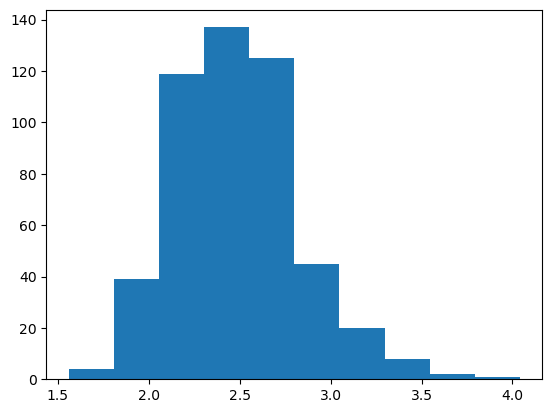

Parma 1 = 0.14184395071429817 +/- 0.01992920673215526


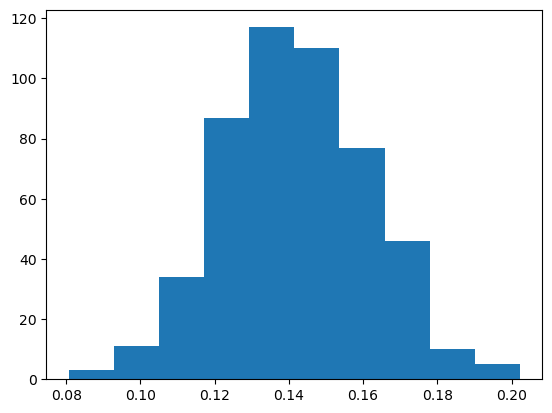

Parma 2 = -0.005251762454364539 +/- 0.003166141498149418


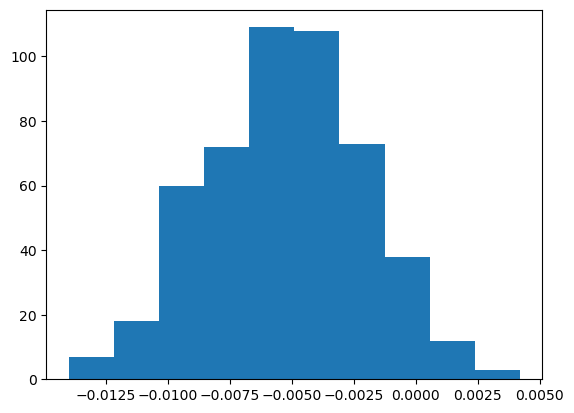

In [59]:
for i in range(len(bparams[0,:])):
    pd = bparams[:,i]
    std_param = np.std(pd) 
    mean_param = np.mean(pd)  # it's actually more accurate to
                             # just use the single fits, but we don't 
                             # necessarily know the name of that results structure
                             # when we are at this point in the code, use the mean for now
    print(f"Parma {i} = {mean_param} +/- {std_param}")
    plt.hist(pd)
    plt.show()

In [60]:
full_opt=results.x
print(full_opt)

[ 1.72168609  0.19379308 -0.01261432]


Note that the standard deviations of the parameters are lower with the maximum likelihood approximation.

B: 
weighted: 1.33 +/- 0.65
ML: 2.54 +/- 0.44

$\alpha_1$: 
weighted: 0.357 +/- 0.127
ML: 0.223 +/- 0.025

$\alpha_2$: 
weighted: -0.0317 +/- 0.0102
ML:  -0.0205 +/- 0.0041

Note that it is OK that the uncertainties are not within each other, since this is a highly correlated problem, so there are multiple solutions - small change in optimization can lead to large changes in the parameters while still being relatively close. 

In [61]:
def osmotic_pressure(cs,params, nu=2):
    # takes in a concentration, model parameters and nu. 
    term1 = cs
    term2 = params[1]*0.5*cs**2
    term3 = params[2]*(1/3.0)*cs**3
    csh = np.sqrt(cs)
    B = params[0]
    Bf = 1+B*csh
    term4 = (A/B**2)*((2/B)*np.log(Bf) - (2*csh+B*cs)/Bf)    
    p = nu*R*T*(term1+term2+term3+term4)
    ip = nu*R*T*cs  # this should be the ideal osmotic pressure
    return p,p/ip

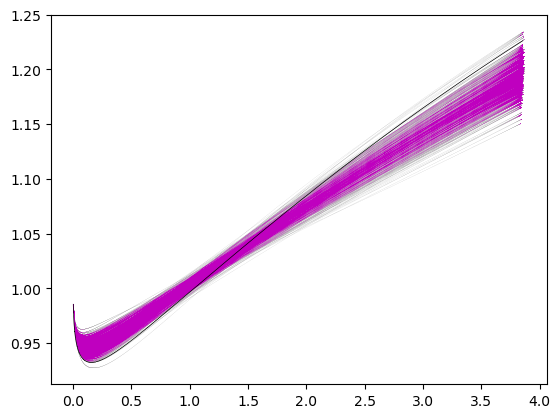

In [62]:
# scatter plots of the osmotic coefficients and osmotic pressures
ops = list()
ocs = list()
for p,c in zip(bparams,bcs):
    op,oc = osmotic_pressure(c,p)
    plt.scatter(c,oc,s=0.1,lw=0.1,alpha=0.01,c='m')
    ops.append(op)
    ocs.append(oc)
opt_oc = osmotic_pressure(c_opt_sparse_all,full_opt)[1]
plt.plot(c_opt_sparse_all,opt_oc,'k',lw=0.5,)
ops = np.array(ops)
ocs = np.array(ocs)
plt.show()

In [64]:
def find_closest(lst, target):
    closest_index = min(range(len(lst)), key=lambda i: abs(lst[i] - target))
    closest_value = lst[closest_index]
    return closest_index, closest_value

# Example usage
my_list = c_opt_sparse_all
target_values = [0.976,1.923,2.823]
for target_value in target_values:
    closest_index, closest_value = find_closest(my_list, target_value)
    print(f"The closest value to {target_value} is {closest_value} at index {closest_index} and osmotic coefficient is {opt_oc[closest_index]} +/-")

The closest value to 0.976 is 0.975888729095459 at index 5990 and osmotic coefficient is 0.9944226145744324 +/-
The closest value to 1.923 is 1.9235247373580933 at index 4362 and osmotic coefficient is 1.0781959295272827 +/-
The closest value to 2.823 is 2.8230090141296387 at index 2938 and osmotic coefficient is 1.151239037513733 +/-


[0.9758887, 1.9235247, 2.823009]
[0.9944226, 1.0781959, 1.151239]
[0.0035605880832355608, 0.014783572443411108, 0.03093747019568771]
[0.011809847809344909, 0.0019262716005117309, 0.010096291665777635]


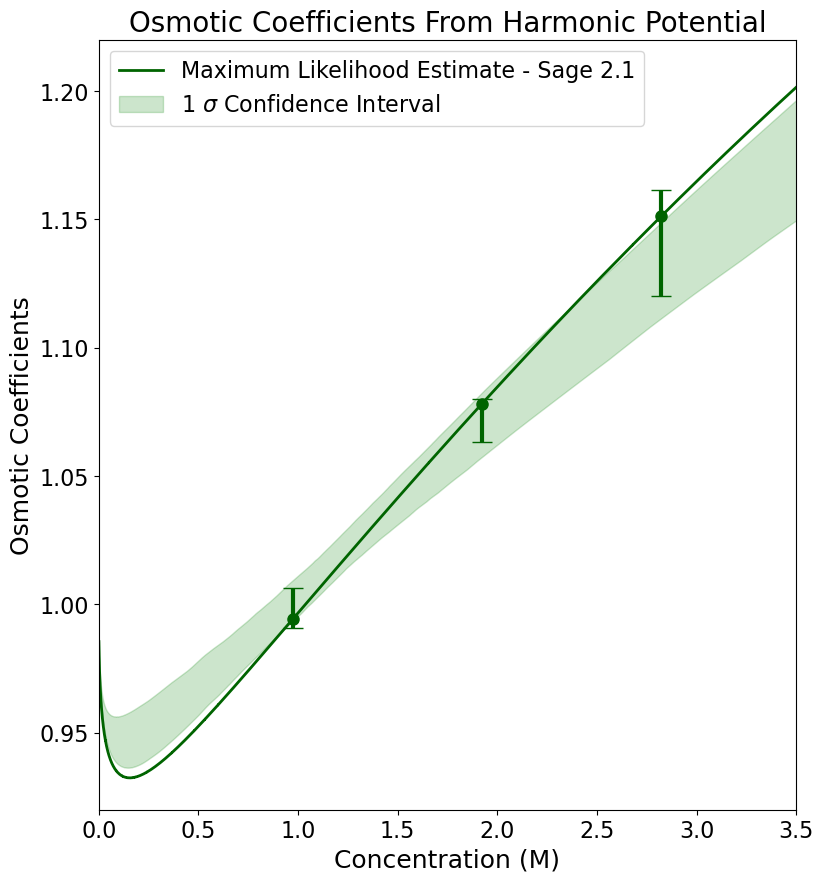

In [73]:
lower_bound = np.percentile(ocs, 2.5, axis=0)
upper_bound = np.percentile(ocs, 97.5, axis=0)

indices = [5990, 4362, 2938]  
lower_bound_1sigma = np.percentile(ocs, 16, axis=0)
upper_bound_1sigma = np.percentile(ocs, 84, axis=0)
# Extract the specific points and their error bars
x_values = [c_opt_sparse_all[i] for i in indices]
print(x_values)
y_values = [opt_oc[i] for i in indices]
print(y_values)
y_error_lower = [np.abs(y_values[i] - lower_bound_1sigma[indices[i]]) for i in range(3)]
print(y_error_lower)
y_error_upper = [np.abs(upper_bound_1sigma[indices[i]] - y_values[i]) for i in range(3)]
print(y_error_upper)
# Plotting the results
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(9.0,10.0))
plt.plot(c_opt_sparse_all, opt_oc, lw=2, label='Maximum Likelihood Estimate - Sage 2.1', color='darkgreen')
plt.fill_between(c_opt_sparse_all, lower_bound, upper_bound, color='g', alpha=0.2, label='1 $\sigma$ Confidence Interval')
plt.errorbar(x_values, y_values, yerr=[y_error_lower, y_error_upper], fmt='o', color='darkgreen', capsize=7, markersize=8, lw=3)
plt.xlabel("Concentration (M)", fontsize=MEDIUM_SIZE)
plt.ylabel('Osmotic Coefficients', fontsize=MEDIUM_SIZE)
plt.legend()
plt.xlim(0.0,3.5)
plt.ylim(0.92,1.22)
plt.title('Osmotic Coefficients From Harmonic Potential', fontsize=BIGGER_SIZE)
plt.savefig('oc.png', dpi=1000)
plt.show()


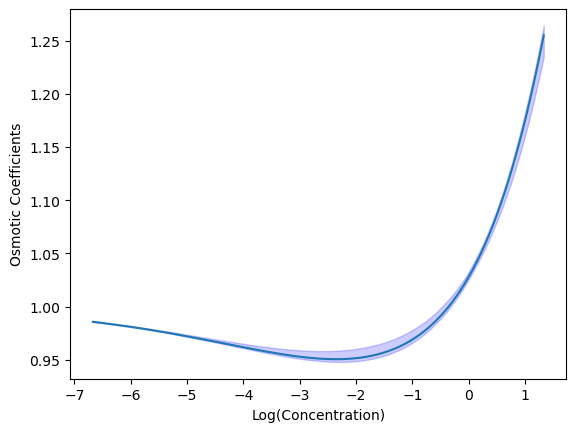

In [ ]:

plt.plot(np.log(c_opt_sparse_all), opt_oc, label='Mean Profile')
plt.fill_between(np.log(c_opt_sparse_all), lower_bound, upper_bound, color='b', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Log(Concentration)')
plt.ylabel('Osmotic Coefficients')
plt.show()